In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout
%matplotlib inline
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
path = os.getcwd()
print(path)

C:\home\program


In [3]:
os.chdir('../')

In [4]:
df = pd.read_csv('program/stock2.csv', encoding="shift_jis")
L = len(df)
Y = df.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [5]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [6]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [7]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [8]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [9]:
# train, testデータを定義
X_train = X[:350, :, :]
X_test = X[350:, :, :]
Y_train = Y[:350, :]
Y_test = Y[350:, :]

In [10]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.5533 - mean_absolute_error: 0.7410
Epoch 2/50
 - 0s - loss: 0.4606 - mean_absolute_error: 0.6762
Epoch 3/50
 - 0s - loss: 0.3903 - mean_absolute_error: 0.6220
Epoch 4/50
 - 0s - loss: 0.3267 - mean_absolute_error: 0.5688
Epoch 5/50
 - 0s - loss: 0.2682 - mean_absolute_error: 0.5150
Epoch 6/50
 - 0s - loss: 0.2145 - mean_absolute_error: 0.4604
Epoch 7/50
 - 0s - loss: 0.1664 - mean_absolute_error: 0.4048
Epoch 8/50
 - 0s - loss: 0.1239 - mean_absolute_error: 0.3489
Epoch 9/50
 - 0s - loss: 0.0877 - mean_absolute_error: 0.2925
Epoch 10/50
 - 0s - loss: 0.0577 - mean_absolute_error: 0.2363
Epoch 11/50
 - 0s - loss: 0.0344 - mean_absolute_error: 0.1804
Epoch 12/50
 - 0s - loss: 0.0179 - mean_absolute_error: 0.1270
Epoch 13/50
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0786
Epoch 14/50
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0415
Epoch 15/50
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0273
Epoch 16/50
 - 0s - loss: 0.0011 - mean_absolute_error: 0.0258
E

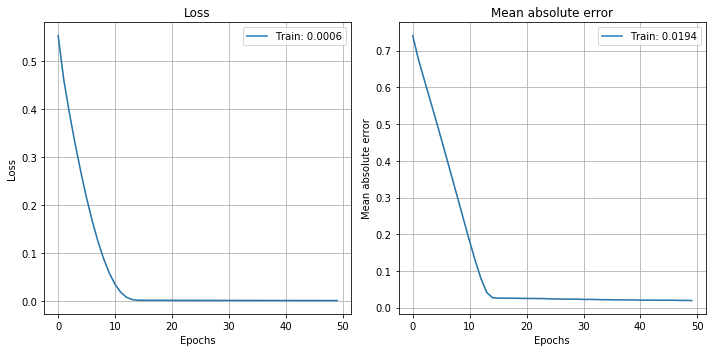

In [11]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
Predict = model.predict(X_test)

In [12]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[3:353,0])

In [13]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[353:,0])

In [14]:
Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)
Predict.index=pd.to_datetime(df.iloc[353:,0])

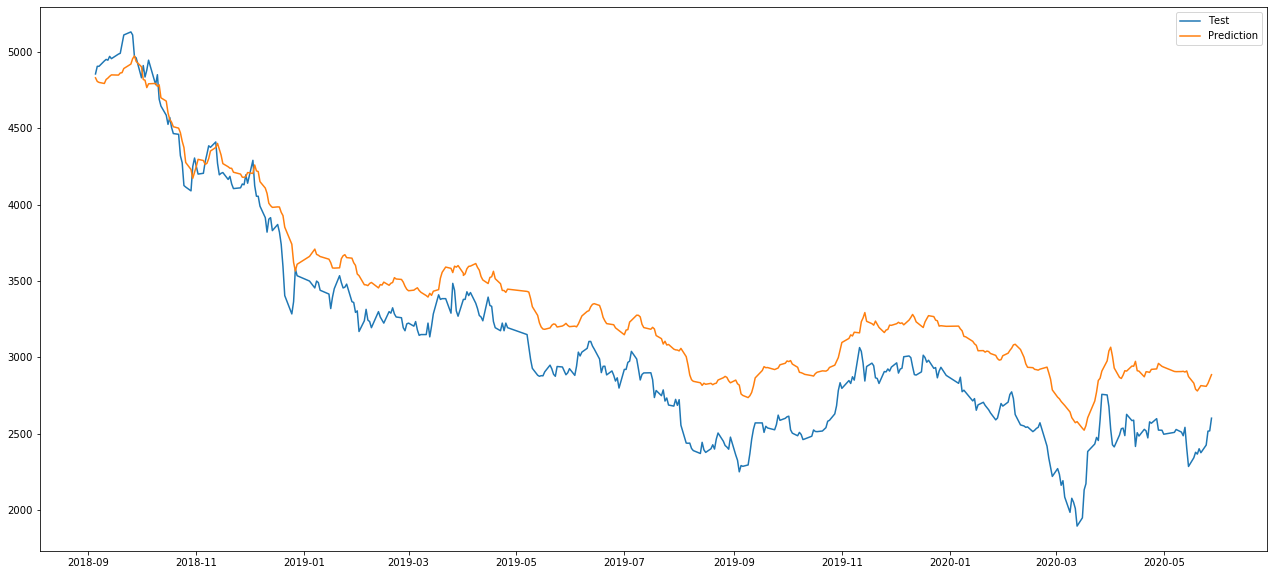

In [15]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [16]:
df['day'] = pd.to_datetime(df['day'], format='%Y/%m/%d')
timeSeries = df.loc[:, ["day","end"]]
timeSeries.index = timeSeries.day
ts = timeSeries.drop("day",axis=1)

In [17]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(Predict[0], order=(2,0,2)).fit(dist=False)
arima_model2 = ARIMA(ts, order=(2,0,2)).fit(dist=False)

C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [18]:
arima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    end   No. Observations:                  769
Model:                     ARMA(2, 2)   Log Likelihood               -4273.229
Method:                       css-mle   S.D. of innovations             62.451
Date:                Mon, 27 Jul 2020   AIC                           8558.459
Time:                        13:15:12   BIC                           8586.330
Sample:                             0   HQIC                          8569.186
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3711.4945    697.324      5.322      0.000    2344.765    5078.224
ar.L1.end      1.5913      0.088     18.048      0.000       1.418       1.764
ar.L2.end     -0.5922      0.088     -6.732      0.000      -0.765      -0.420
ma.L1.end     -0.5529      0.095     -5.850      0.000      -0.738      -0.368
ma.L2.end     -0.0388      0.033     -1.163      0.245      -0.104       0.027
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0022           +0.0000j            1.0022            0.0000
AR.2            1.6849           +0.0000j            1.6849            0.0000
MA.1            1.6236           +0.0000j            1.6236            0.0000
MA.2          -15.8700           +0.0000j           15.8700            0.5000
-----------------------------------------------------------------------------
"""

In [19]:
forecast = arima_model.predict()
forecast2 = arima_model2.predict()

In [20]:
y_forecasted = np.exp(arima_model.predict()/10)
y_truth = np.exp(Y_test['2018-09-05':'2020-05-28']/10)

In [21]:
y_truth[0]

day
2018-09-05    7.078985e+210
2018-09-06    1.050614e+213
2018-09-07    1.050614e+213
2018-09-10    3.479157e+214
2018-09-11    9.457330e+214
                  ...      
2020-05-22    1.705290e+103
2020-05-25    2.530875e+105
2020-05-26    2.266473e+109
2020-05-27    2.768276e+109
2020-05-28    1.113919e+113
Name: 0, Length: 416, dtype: float64

In [22]:
rmse = np.sqrt(((y_forecasted - y_truth[0]) ** 2).mean())
print('RMSE = {}'.format(round(rmse, 4)))

RMSE = inf


C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 32066 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0, flags=flags)


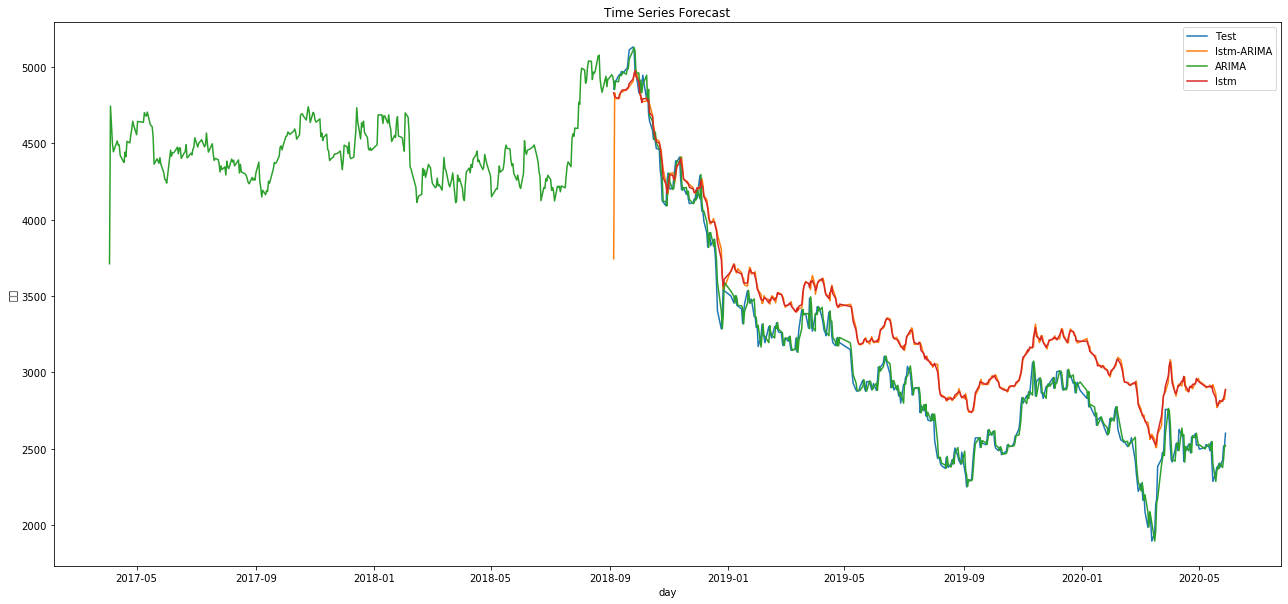

In [23]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(forecast,label = "lstm-ARIMA")
plt.plot(forecast2,label = "ARIMA")
#plt.plot(forecast3,label = "lstm-ARIMA--5")
#plt.plot(forecast4,label = "ARIMA--5")
plt.plot(Predict, label = 'lstm')
plt.title("Time Series Forecast")
plt.xlabel("day")
plt.ylabel("終値")
plt.legend()
plt.show()

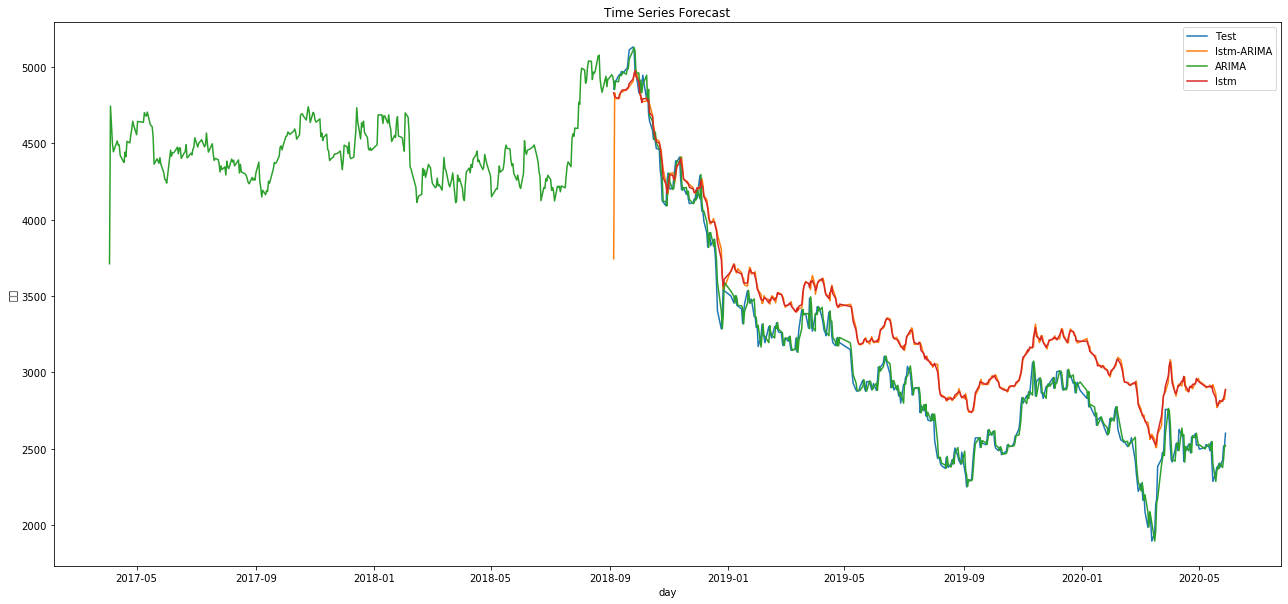

In [24]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(forecast,label = "lstm-ARIMA")
plt.plot(forecast2,label = "ARIMA")
plt.plot(Predict, label = 'lstm')
plt.title("Time Series Forecast")
plt.xlabel("day")
plt.ylabel("終値")
plt.legend()
plt.show()

In [25]:
LA_error = forecast-Y_test[0]
A_error = forecast-Y_test[0]
L_error = Predict[0]-Y_test[0]
zero = Y_test
zero[0] = 0

In [26]:
LA_rows_to_drop = LA_error.index[LA_error >= 500]
A_rows_to_drop = A_error.index[A_error >= 500]
L_rows_to_drop = L_error.index[L_error >= 500]

In [27]:
LA = LA_error.drop(LA_rows_to_drop)
A = A_error.drop(A_rows_to_drop)
L = L_error.drop(L_rows_to_drop)

C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22793 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 22793 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\home\anaconda\envs\TF\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 21270 missing from curre

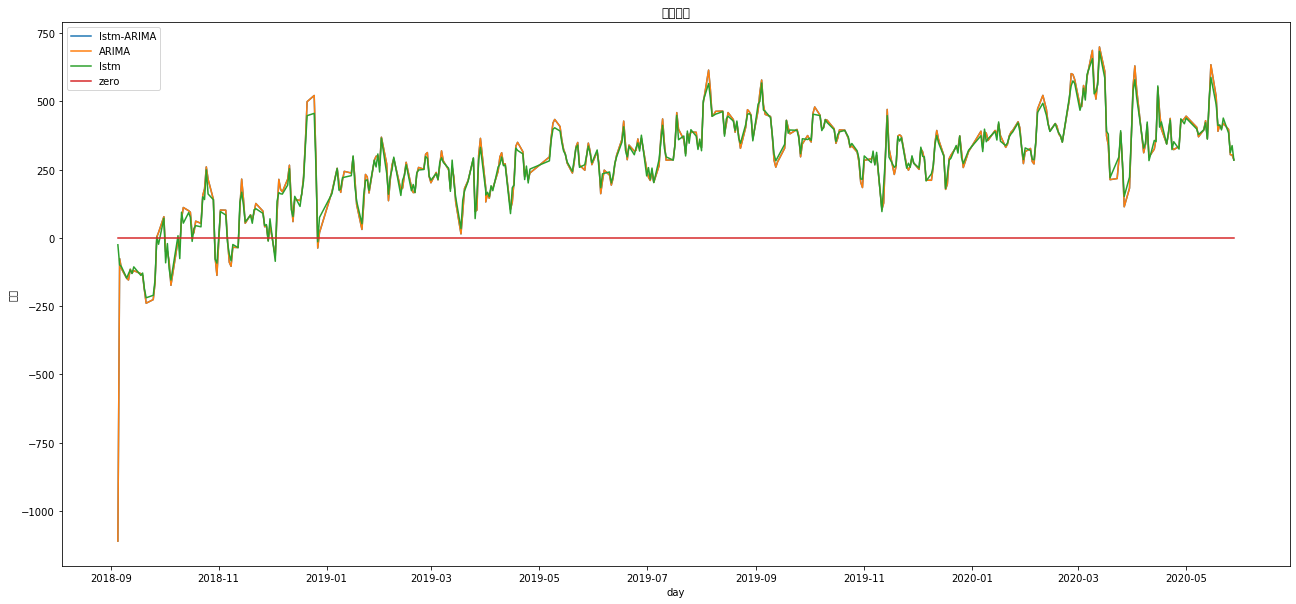

In [28]:
plt.figure(figsize=(22,10))
plt.plot(LA_error,label = "lstm-ARIMA")
plt.plot(A_error,label = "ARIMA")
plt.plot(L_error,label = "lstm")
plt.plot(zero,label = "zero")
plt.title("値の変化")
plt.xlabel("day")
plt.ylabel("終値")
plt.legend()
plt.show()

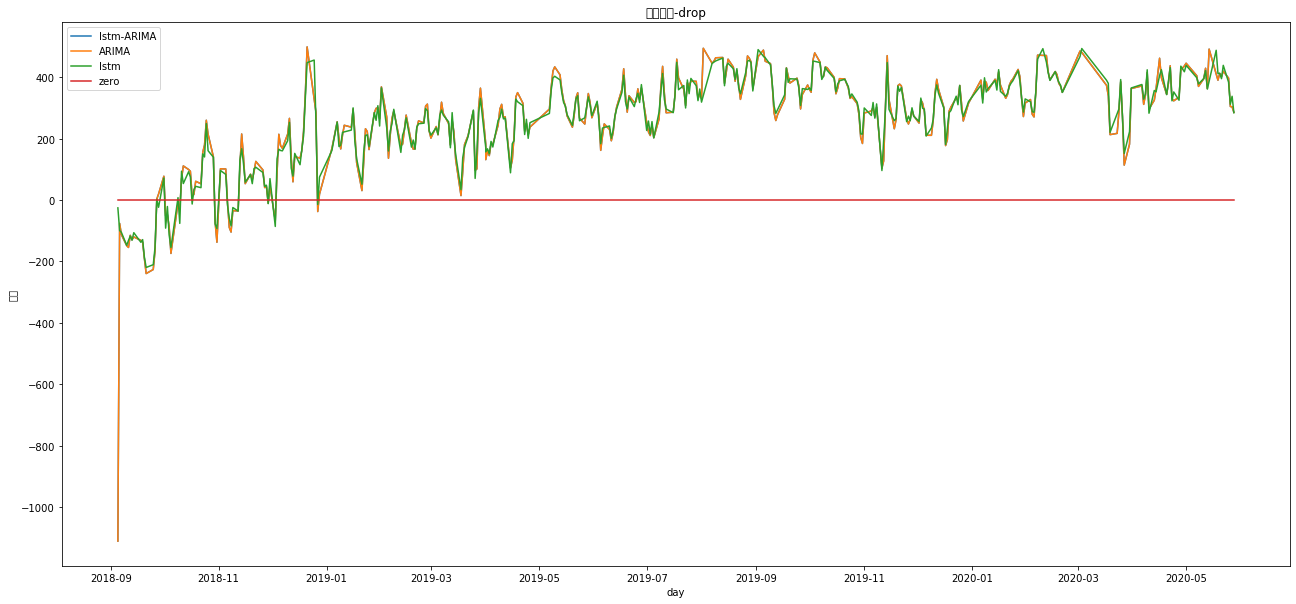

In [29]:
plt.figure(figsize=(22,10))
plt.plot(LA,label = "lstm-ARIMA")
plt.plot(A,label = "ARIMA")
plt.plot(L,label = "lstm")
plt.plot(zero,label = "zero")
plt.title("値の変化-drop")
plt.xlabel("day")
plt.ylabel("終値")
plt.legend()
plt.show()

In [30]:
#LA = LA.drop_duplicates()
LA[LA.index.duplicated(keep=False)]
print(LA.resample('D').interpolate())

ValueError: cannot reindex from a duplicate axis

In [31]:
LA.index=="2019-04-01"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [32]:
print(LA.index.get_loc("2019-04-01"))

slice(135, 137, None)


In [33]:
LA.index[137]

Timestamp('2019-04-02 00:00:00')

In [34]:
LA.index[136]

Timestamp('2019-04-01 00:00:00')

In [35]:
i_index = list(LA.index)

In [36]:
LA = LA.drop(LA.index[[136, 137]])

In [37]:
LA[LA.index.duplicated(keep=False)]

Series([], dtype: float64)

In [42]:
LA = LA.resample('D').interpolate()

In [43]:
LA

day
2018-09-05   -1110.943390
2018-09-06     -76.014153
2018-09-07    -112.619529
2018-09-08    -124.552310
2018-09-09    -136.485090
                 ...     
2020-05-24     404.769472
2020-05-25     397.237878
2020-05-26     304.944288
2020-05-27     303.997760
2020-05-28     285.727684
Freq: D, Length: 632, dtype: float64

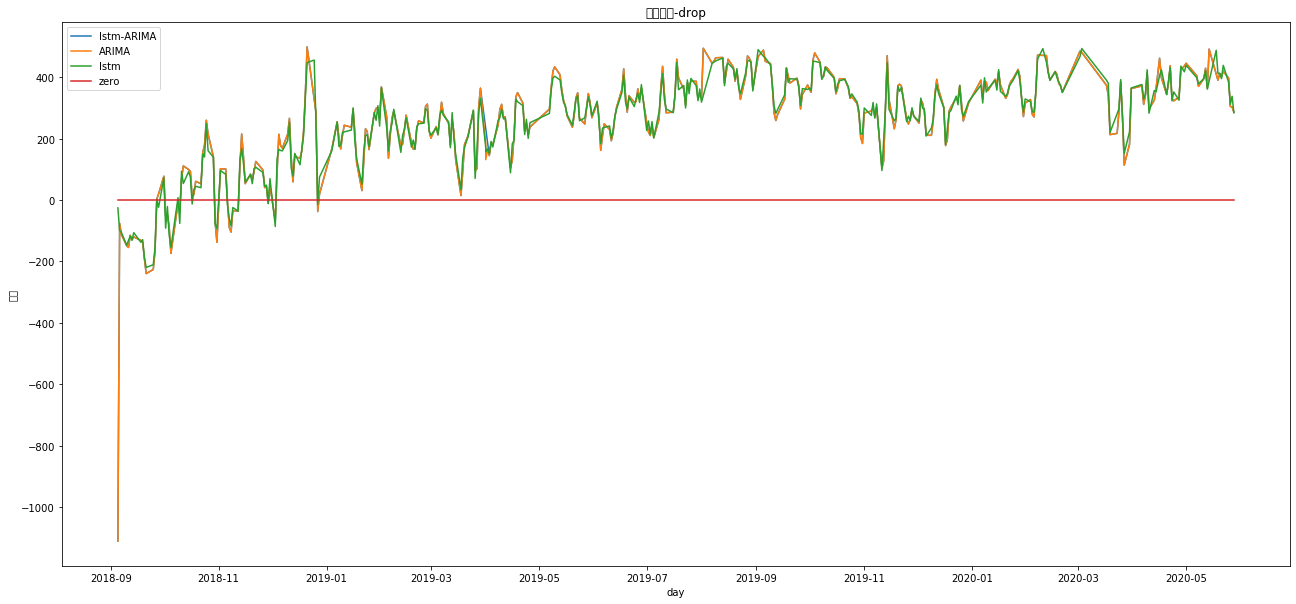

In [44]:
plt.figure(figsize=(22,10))
plt.plot(LA,label = "lstm-ARIMA")
plt.plot(A,label = "ARIMA")
plt.plot(L,label = "lstm")
plt.plot(zero,label = "zero")
plt.title("値の変化-drop")
plt.xlabel("day")
plt.ylabel("終値")
plt.legend()
plt.show()